# Set up and Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2, VGG16, VGG19, MobileNetV2
from tensorflow.keras.applications.resnet_v2 import preprocess_input as preprocess_resnet50v2
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.vgg19 import preprocess_input as preprocess_vgg19
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2
from tensorflow.keras.utils import to_categorical

2025-06-29 19:36:56.388835: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751225816.600865      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751225816.662734      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Splitting Data into Directories

In [2]:
import shutil

def split_data(source_dir, output_dir, train_ratio=0.7, val_ratio=0.15):
    classes = os.listdir(source_dir)
    for cls in classes:
        class_path = os.path.join(source_dir, cls)
        images = os.listdir(class_path)
        random.shuffle(images)

        train_split = int(train_ratio * len(images))
        val_split = int((train_ratio + val_ratio) * len(images))

        train_imgs = images[:train_split]
        val_imgs = images[train_split:val_split]
        test_imgs = images[val_split:]

        for img_set, set_name in zip([train_imgs, val_imgs, test_imgs], ['train', 'val', 'test']):
            dst_dir = os.path.join(output_dir, set_name, cls)
            os.makedirs(dst_dir, exist_ok=True)
            for img in img_set:
                src_img_path = os.path.join(class_path, img)
                dst_img_path = os.path.join(dst_dir, img)
                try:
                    shutil.copy(src_img_path, dst_img_path)
                except:
                    print(f"Error copying {src_img_path}")

# Call it with your paths
split_data("/kaggle/input/lung-cancer-histopathological-images", "lung_split_dataset")


# Reading all training data from directories

- present sample of each class

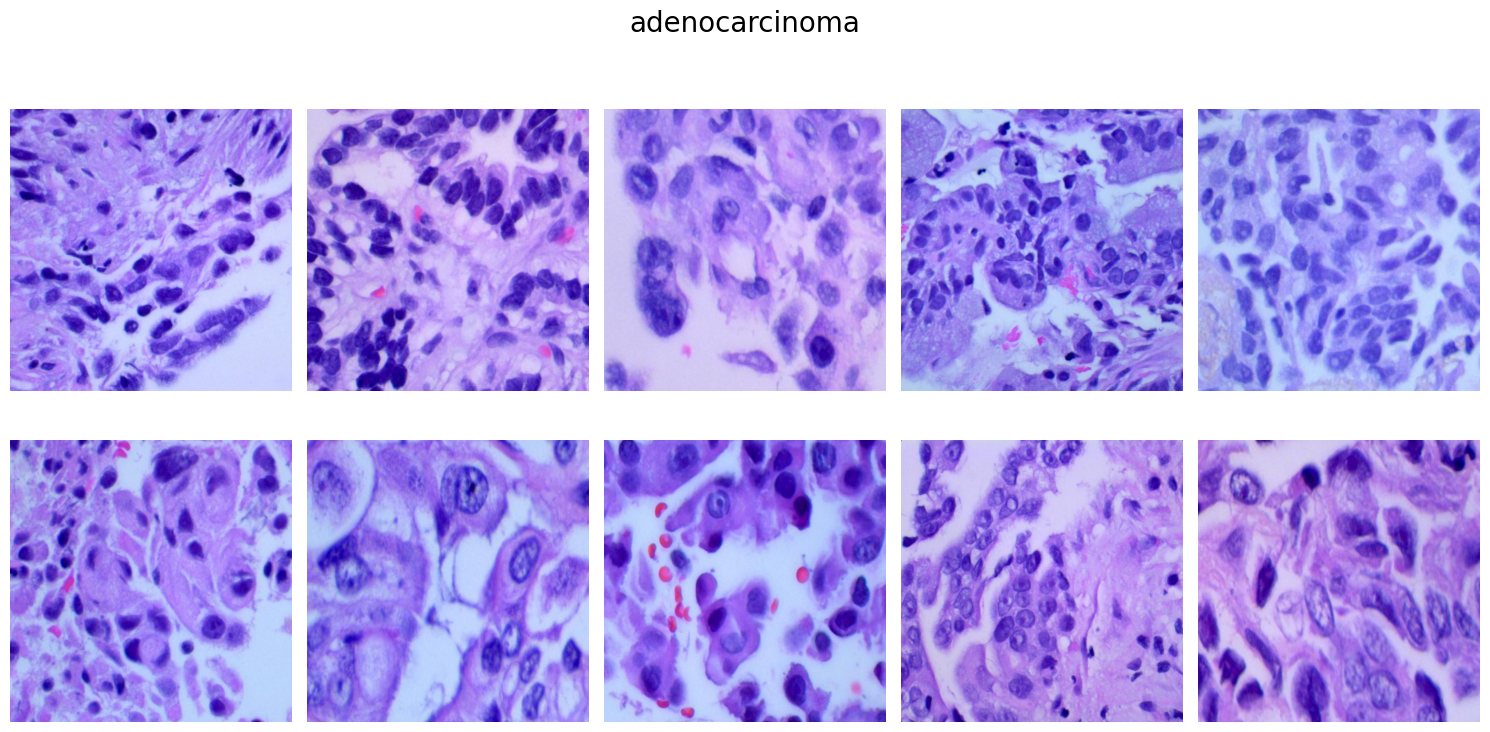

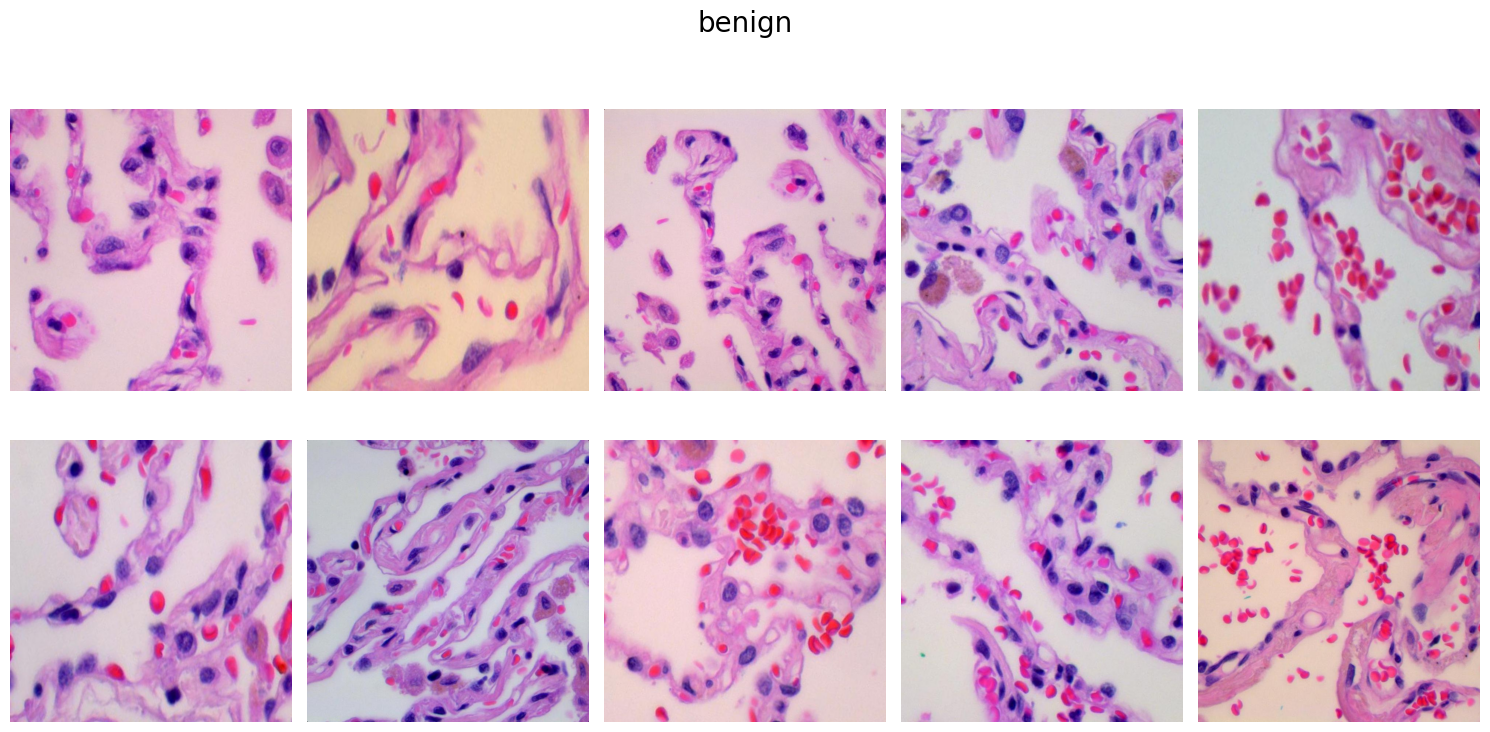

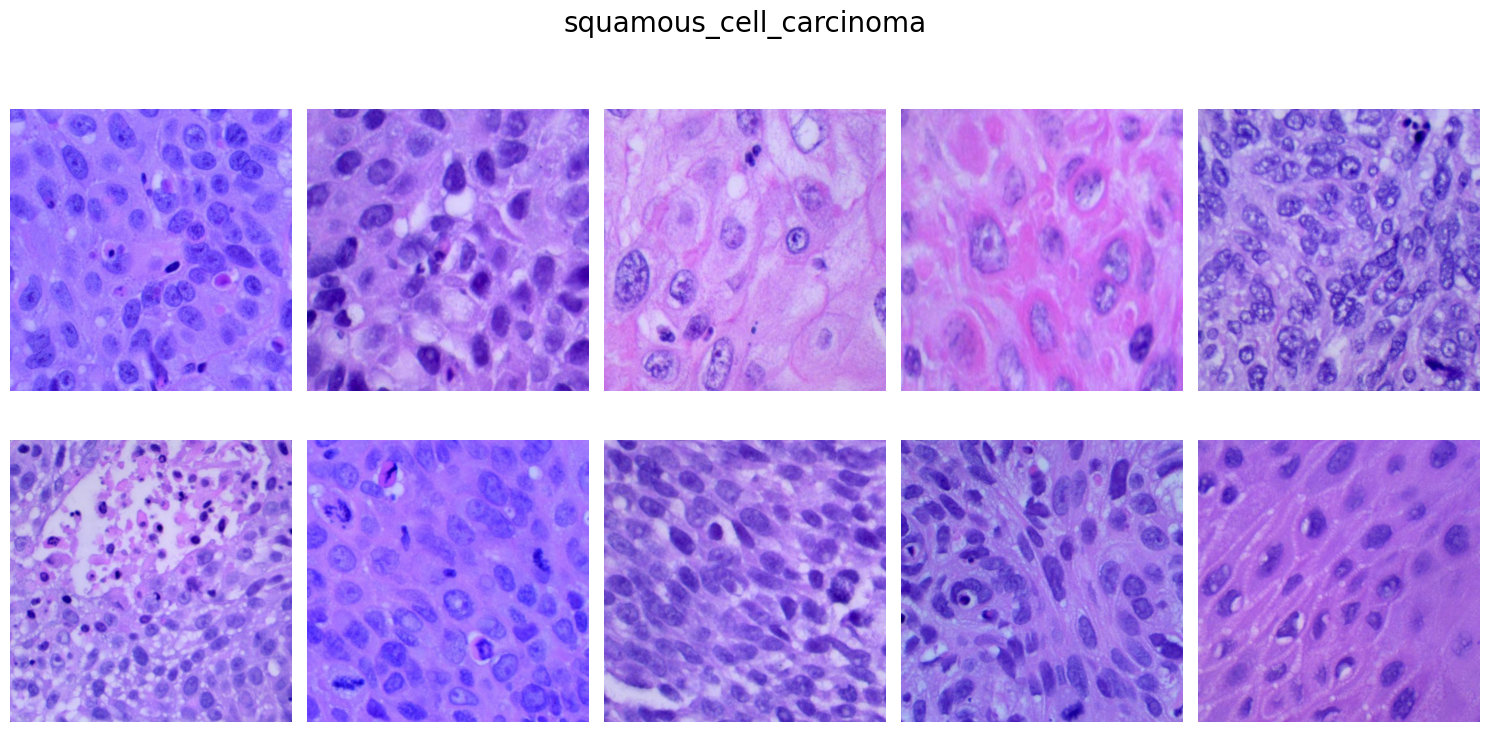

In [3]:
DATADIR = '/kaggle/working/lung_split_dataset/train'
CATEGORIES = ['adenocarcinoma', 'benign', 'squamous_cell_carcinoma']

for category in CATEGORIES:  
    path = os.path.join(DATADIR, category)
    images = os.listdir(path)
    
    plt.figure(figsize=(15, 8))
    plt.suptitle(category, fontsize=20)  # Title for the category
    
    for i, img_name in enumerate(images[:10]):  # just first 10 images
        img_array = cv2.imread(os.path.join(path, img_name))
        img_array = cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB)
        plt.subplot(2, 5, i+1)  # 2 rows, 5 columns
        plt.imshow(img_array)
        plt.axis('off')  # hide axis labels
       
    
    plt.tight_layout()
    plt.show()   

In [4]:
print(img_array)
print(img_array.shape)

[[[145  96 214]
  [148  99 217]
  [151 102 219]
  ...
  [158 105 223]
  [157 104 220]
  [157 104 220]]

 [[140  90 211]
  [143  93 214]
  [146  97 215]
  ...
  [159 106 224]
  [158 105 221]
  [158 105 221]]

 [[132  83 208]
  [135  86 211]
  [138  89 214]
  ...
  [161 108 226]
  [160 107 225]
  [159 106 224]]

 ...

 [[175 118 215]
  [175 118 213]
  [176 119 214]
  ...
  [122  74 196]
  [118  72 196]
  [118  72 196]]

 [[180 120 216]
  [180 123 218]
  [181 124 219]
  ...
  [120  71 196]
  [117  71 195]
  [116  72 195]]

 [[184 124 220]
  [185 125 221]
  [186 129 223]
  ...
  [118  72 196]
  [116  70 194]
  [115  71 194]]]
(768, 768, 3)


### resize image and show one of them 

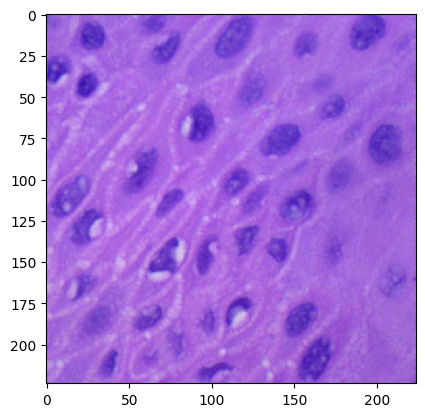

In [5]:
IMG_SIZE = 224   # test resize of images

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

# CNN Model

## CNN Data Generator

In [6]:
train_path = '/kaggle/working/lung_split_dataset/train'
val_path = '/kaggle/working/lung_split_dataset/val'
test_path = '/kaggle/working/lung_split_dataset/test'

In [7]:
IMG_SIZE = 224
batch_size = 32

In [8]:
def cnn_preprocess(x):
    return x/255.0

In [9]:
cnn_train_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_train_generator = cnn_train_datagen.flow_from_directory(
        train_path,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical')

Found 10500 images belonging to 3 classes.


In [10]:
cnn_train_generator.class_indices

{'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}

## visualize the percentage of each class in data

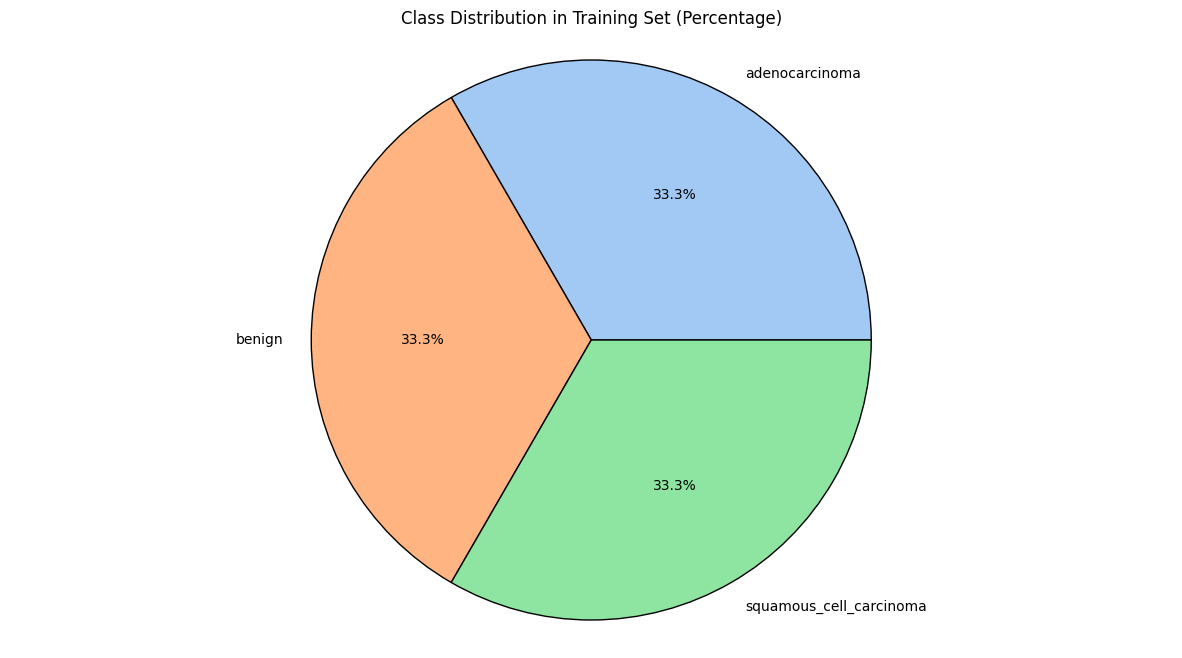

In [11]:
y_train = cnn_train_generator.classes  
# Count occurrences of each class
class_counts = np.bincount(y_train)

# Plot the pie chart
plt.figure(figsize=(15, 8))
plt.pie(class_counts,
        labels=CATEGORIES,
        autopct='%1.1f%%',
        colors=sns.color_palette('pastel'),
        wedgeprops={'edgecolor': 'black'})

plt.title("Class Distribution in Training Set (Percentage)", loc='center')
plt.axis('equal') 
plt.show()

In [12]:
cnn_val_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_val_generator = cnn_val_datagen.flow_from_directory(
        val_path,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical')

Found 2250 images belonging to 3 classes.


In [13]:
cnn_val_generator.class_indices

{'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}

## CNN Modeling

In [14]:
cnn_model1 = keras.Sequential([
    keras.layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dropout(0.4),

    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dense(units=64, activation='relu'),

    keras.layers.Dense(units=len(cnn_val_generator.class_indices), activation='softmax', dtype='float32')
])

I0000 00:00:1751225920.498185      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [15]:
cnn_model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,200,899 (42.73 MB)

 Trainable params: 11,200,899 (42.73 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',    
        patience=5,             
        restore_best_weights=True
    ),
    
    ModelCheckpoint(
        filepath='CNN_best_model.keras',  
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False, 
        mode='min',
        verbose=1
    )
]

In [17]:
cnn_model1.compile(optimizer=keras.optimizers.Adam(), 
              loss=keras.losses.CategoricalCrossentropy(), 
               metrics=['accuracy',keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')
])

In [18]:
cnn1_history = cnn_model1.fit(
        cnn_train_generator,
        epochs = 20,
        validation_data = cnn_val_generator,
        callbacks = callbacks
        )

Epoch 1/20


I0000 00:00:1751225926.552115     111 service.cc:148] XLA service 0x11dbf380 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751225926.552957     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1751225926.936494     111 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/329 ━━━━━━━━━━━━━━━━━━━━ 52:28 10s/step - accuracy: 0.2188 - loss: 1.1097 - precision: 0.0000e+00 - recall: 0.0000e+00

I0000 00:00:1751225931.579119     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.7364 - loss: 0.5369 - precision: 0.7704 - recall: 0.6982
Epoch 1: val_loss improved from inf to 0.21278, saving model to CNN_best_model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 64s 164ms/step - accuracy: 0.7370 - loss: 0.5359 - precision: 0.7709 - recall: 0.6989 - val_accuracy: 0.9196 - val_loss: 0.2128 - val_precision: 0.9200 - val_recall: 0.9196
Epoch 2/20
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.9042 - loss: 0.2448 - precision: 0.9053 - recall: 0.9035
Epoch 2: val_loss improved from 0.21278 to 0.19829, saving model to CNN_best_model.keras
329/329 ━━━━━━━━━━━━━━━━━━━━ 48s 143ms/step - accuracy: 0.9042 - loss: 0.2448 - precision: 0.9053 - recall: 0.9035 - val_accuracy: 0.9249 - val_loss: 0.1983 - val_precision: 0.9253 - val_recall: 0.9249
Epoch 3/20
328/329 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9380 - loss: 0.1624 - precision: 0.9380 - recall: 0.9380
Epoch 3: val_loss did not improve from 0.19829
329/329 ━━━

## Plotting training and validation loss and accuracy

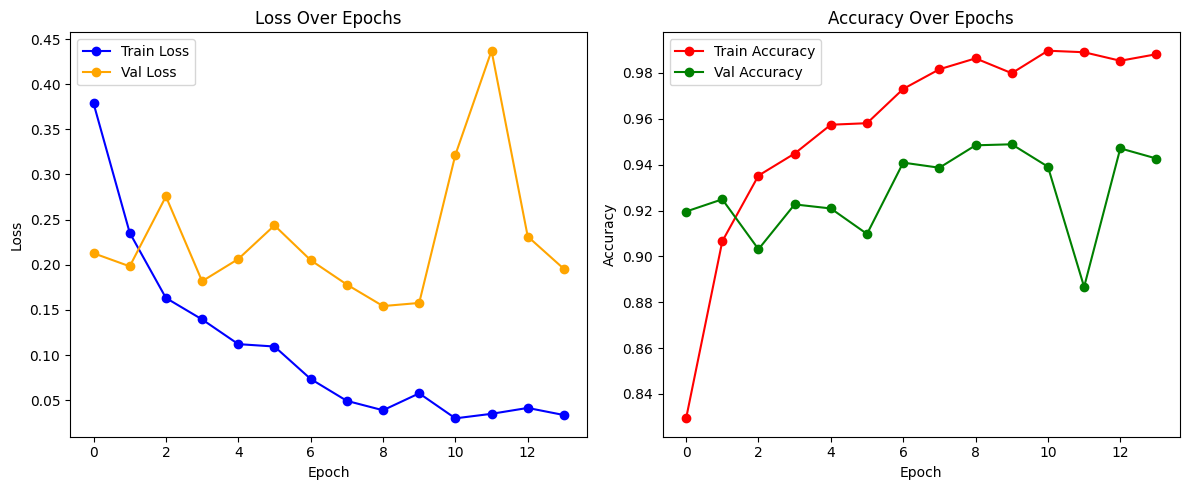

In [19]:
# Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))

# 📉 Loss
plt.subplot(1, 2, 1)
plt.plot(cnn1_history.history['loss'], label='Train Loss', marker='o', color='blue')
plt.plot(cnn1_history.history['val_loss'], label='Val Loss', marker='o', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 📈 Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn1_history.history['accuracy'], label='Train Accuracy', marker='o', color='red')
plt.plot(cnn1_history.history['val_accuracy'], label='Val Accuracy', marker='o', color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evalute CNN1 model 

In [20]:
cnn_test_datagen = ImageDataGenerator(preprocessing_function=cnn_preprocess)
cnn_test_generator = cnn_val_datagen.flow_from_directory(
        test_path,
        target_size=(IMG_SIZE,IMG_SIZE),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
)

Found 2250 images belonging to 3 classes.


In [21]:
cnn_test_generator.class_indices

{'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}

In [22]:
result_cnn1=cnn_model1.evaluate(cnn_test_generator)


71/71 ━━━━━━━━━━━━━━━━━━━━ 9s 122ms/step - accuracy: 0.9663 - loss: 0.1021 - precision: 0.9663 - recall: 0.9663


71/71 ━━━━━━━━━━━━━━━━━━━━ 10s 130ms/step


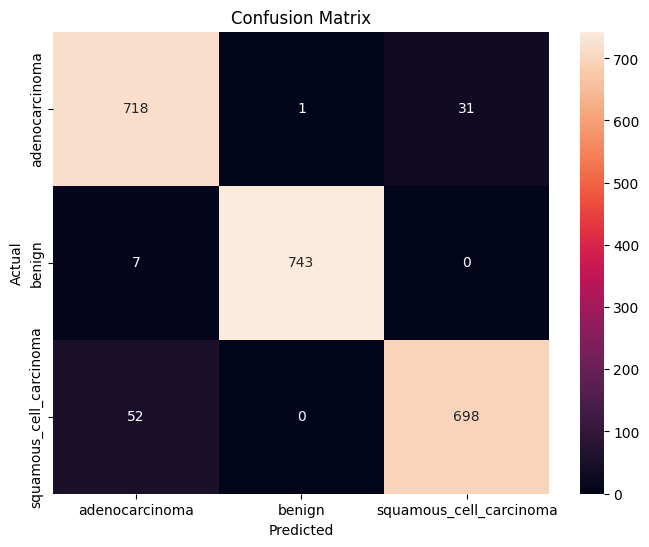

                         precision    recall  f1-score   support

         adenocarcinoma       0.92      0.96      0.94       750
                 benign       1.00      0.99      0.99       750
squamous_cell_carcinoma       0.96      0.93      0.94       750

               accuracy                           0.96      2250
              macro avg       0.96      0.96      0.96      2250
           weighted avg       0.96      0.96      0.96      2250



In [23]:
y_pred_probs =cnn_model1.predict(cnn_test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
# 2. True labels
y_true = cnn_test_generator.classes
# 3. Get class names (ordered by index)
class_names = list(cnn_test_generator.class_indices.keys())
# 4. Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 5. Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))